# Итоговое задание для курса “Профессия ML-инженер”


Цель: Решить одну из предложенных задач используя методы
глубокого обучения или классического компьютерного зрения,
пройденных на курсе.

Задачи:

● Проанализировать существующие решения для выбранной
темы и подобрать релевантный датасет;

● Представить блок-схему или диаграмму пайплайна обучения
и инференса модели(ей), основываясь на найденных
решениях и знаниях, полученных на курсе;

● Написать скрипт для обучения модели(ей);

● Написать интерфейс для работы с обученной моделью(ями);

● Оценить качество модели по выбранным для задачи
метрикам, сравнить качество на валидационной и тестовой
выборках;

● Написать отчет (2-4 стр), который будет включать в себя:

(a) обоснование выбора датасета и метрик,
(b) предложенное
решение,
(c) архитектуру и оценку сложности модели(ей),
(d)
детали обучения,
(e) выводы о пригодности вашего подхода к
решению выбранной задачи;

● Подготовить финальную презентацию проекта.

# Проект 9. Распознавание эмоций на видео
- Реализация модуля поиска лица на видео
- Обучение модели распознавания не менее 5 эмоций
- Реализация интерфейса, позволяющий считывать эмоции
человека с видео или веб-камеры, с выводом результата и
вероятностью эмоций

Использовался датасет https://www.kaggle.com/datasets/msambare/fer2013

Для детекции лица использовался haarcascade_frontalface_default.xml

Обучено три модели EfficientNet, ResNet18, Yolo11. Лучше всего показала себя EfficientNet (Test accuracy 0.67)

In [ ]:
from zipfile import ZipFile
from pathlib import Path
import cv2
import os
import glob
import torch
from torchvision.transforms import v2
import random as random
from PIL import Image

import torch
from torch import nn

from torch.utils.data import DataLoader
from torch.utils.data import Dataset

import torchvision
from mlxtend.plotting import plot_confusion_matrix

from torchvision import datasets
from torchvision import transforms


import matplotlib.pyplot as plt

from typing import Tuple
from typing import Dict
from typing import List

from tqdm.auto import tqdm


from torchinfo import summary

import shutil

import numpy as np
import pandas as pd
import yaml

from os import listdir
from os.path import isfile, join
import PIL
import IPython
from io import BytesIO as StringIO
from torch.autograd import Variable
from IPython.display import clear_output
import gradio as gr
import cv2
from torch.autograd import Variable
from ultralytics import YOLO
from moviepy import ImageSequenceClip
from matplotlib import image as mpimg
import onnxruntime as ort
import onnx

# Подготовка данных

Распаковка датасета

In [ ]:
def extract_data(zipfile_path: Path, destination_path: Path) -> None:

    if destination_path.is_dir():
        print(f"{destination_path} уже существует.")
    else:
        print(f"{destination_path} создается...")
        destination_path.mkdir(parents=True, exist_ok=True)

    if not os.listdir(destination_path):
        with ZipFile(zipfile_path, 'r') as zip:
            print("Распаковка файлов...")
            zip.extractall(destination_path)

            print("Распаковка завершена")
    else:
        print("Файлы уже распакованы")

zipfile_path = Path("archive.zip")
images_path = Path("emotions_dataset")
extract_data(zipfile_path, images_path)

emotions_dataset создается...
Распаковка файлов...
Распаковка завершена


In [ ]:
import os, os.path

print("Кол-во изображений:")
DIRs = [images_path / "train", images_path / "test"]
img_count = 0
for dir in DIRs:
    dir_img_count = 0
    for root_dir, cur_dir, files in os.walk(dir):
        dir_img_count += len(files)
    print(f"В {dir}:",dir_img_count)
    img_count += dir_img_count
print("Всего:", img_count)
print(f"Процент тестовых изображений от всего кол-ва изображений: {(dir_img_count/img_count):.2%}")
test_dir_len = dir_img_count

Кол-во изображений:
В emotions_dataset\train: 28709
В emotions_dataset\test: 7178
Всего: 35887
Процент тестовых изображений от всего кол-ва изображений: 20.00%


Рандомное изображение: emotions_dataset\train\neutral\im2705.png
Класс: neutral


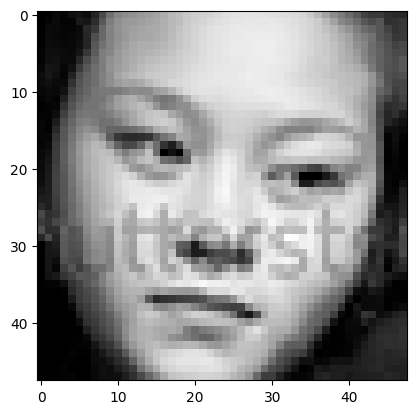

In [ ]:
%matplotlib inline

def print_random_image(images_path: list, seed=None) -> None:
    if seed:
        random.seed(seed)

    random_image_path = random.choice(images_path)
    image_class = random_image_path.parent.stem
    image = Image.open(random_image_path)
    print(f"Рандомное изображение: {random_image_path}")
    print(f"Класс: {image_class}")
    plt.imshow(image.convert('P'))

image_path_list = list(images_path.glob("*/*/*"))
print_random_image(image_path_list)

Аугментация изображений

In [ ]:
train_transform = transforms.Compose(
    [transforms.Resize(size=(224, 224)),
    v2.RandomHorizontalFlip(p=0.5),
    v2.RandomVerticalFlip(p=0.4),
    v2.RandomRotation(degrees=(0, 90)),
    v2.ColorJitter(brightness=random.uniform(1,0.5), contrast=random.random()),
    transforms.ToTensor()]
)

val_transform = transforms.Compose(
    [transforms.Resize(size=(224, 224)),
     transforms.ToTensor()]
)

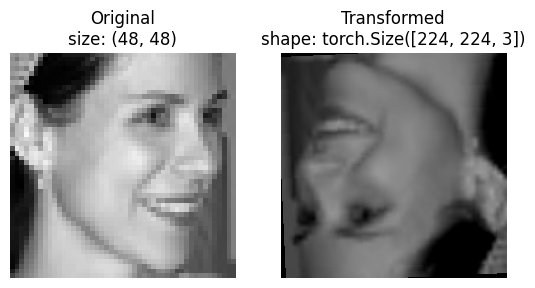

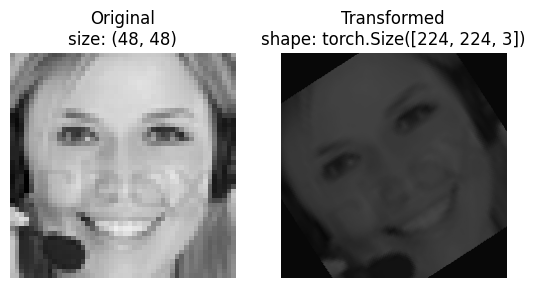

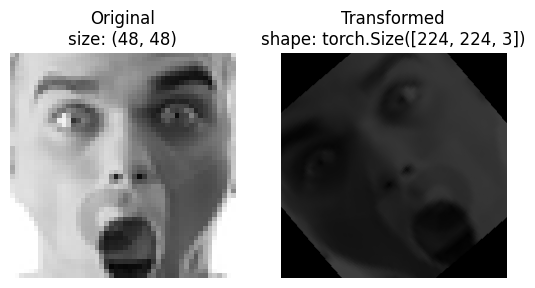

In [ ]:
def plot_transformed_images(images_path: Path,
                            transform: transforms,
                            n: int=3,
                            seed=None) -> None:
    if seed:
        random.seed(seed)

    if n > 10:
        print("n shouldn't be higher than 10 due to the size of displayed plot, changing n to 10")
        n = 10

    random_image_paths = random.sample(images_path, k=n)

    for image_path in random_image_paths:
        with Image.open(image_path).convert('RGB') as f:
            fig, ax = plt.subplots(nrows=1, ncols=2)
            ax[0].imshow(f)
            ax[0].set_title(f"Original\nsize: {f.size}")
            ax[0].axis(False)

            transformed_image = transform(f).permute(1, 2, 0)
            ax[1].imshow(transformed_image)
            ax[1].set_title(f"Transformed\nshape: {transformed_image.shape}")
            ax[1].axis(False)


plot_transformed_images(image_path_list, train_transform)

Создается папка с валидационными данными

In [ ]:
train_path = images_path / "train"
validation_path = images_path / "validation"

for dir_name in [name for name in os.listdir(train_path)]:
    validation_dir_path = validation_path / dir_name
    for root, dir, files in os.walk(train_path / dir_name):
        dir_len = len(files)
        file_count = 0
        for file in files:
            if (file_count/dir_len)*100 <= 20.0:
                file_count +=1
                if not os.path.exists(validation_dir_path):
                    os.makedirs(validation_dir_path)
                shutil.move(os.path.join(root, file), validation_dir_path)

In [ ]:
import os, os.path

print("Кол-во изображений:")
DIRs = [images_path / "train", images_path / "validation", images_path / "test"]
img_count = 0
for dir in DIRs:
    dir_img_count = 0
    for root_dir, cur_dir, files in os.walk(dir):
        dir_img_count += len(files)
    print(f"В {dir}:",dir_img_count)
    img_count += dir_img_count
print("Всего:", img_count)
print(f"Процент тестовых изображений от всего кол-ва изображений: {(dir_img_count/img_count):.2%}")
test_dir_len = dir_img_count

Кол-во изображений:
В emotions_dataset\train: 22961
В emotions_dataset\validation: 5748
В emotions_dataset\test: 7178
Всего: 35887
Процент тестовых изображений от всего кол-ва изображений: 20.00%


In [ ]:
train_path = images_path / "train"
validation_path = images_path / "validation"
test_path = images_path / "test"

train_data = datasets.ImageFolder(
    root=train_path,
    transform=train_transform
)

val_data = datasets.ImageFolder(
    root=validation_path,
    transform=val_transform
)

test_data = datasets.ImageFolder(
    root=test_path,
    transform=val_transform
)


Визуализация датасета

In [ ]:
from os import scandir

def get_file_paths_scandir(directory):
    entries = list(scandir(directory))
    dirs_in_directory = [entry.path for entry in entries if entry.is_dir()]

    return dirs_in_directory

In [ ]:
def count_classes(path, name):
    classes_dict = {}

    for dir in get_file_paths_scandir(path):
        classes_dict[os.path.basename(dir)] = len(list(scandir(dir)))

    df = pd.DataFrame(classes_dict, index=[name])

    return df

train_count = count_classes(train_path, 'Train').transpose().sort_values(by="Train", ascending=False)
test_count = count_classes(test_path, 'Test').transpose().sort_values(by="Test", ascending=False)
val_count = count_classes(validation_path, 'Val').transpose().sort_values(by="Val", ascending=False)

In [ ]:
pd.concat([train_count,test_count, val_count] , axis=1)

,Train,Test,Val
happy,5771,1774,1444
neutral,3971,1233,994
sad,3863,1247,967
fearful,3277,1024,820
angry,3195,958,800
surprised,2536,831,635
disgusted,348,111,88


<Axes: >

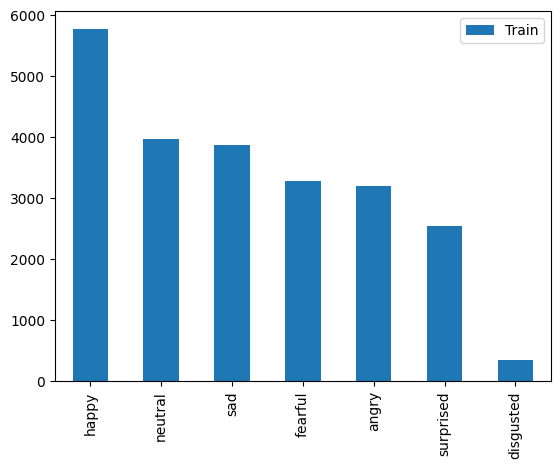

In [ ]:
train_count.plot(kind='bar')

<Axes: >

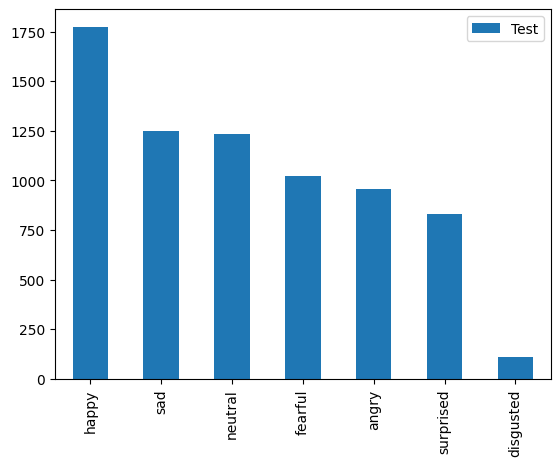

In [ ]:
test_count.plot(kind='bar')

<Axes: >

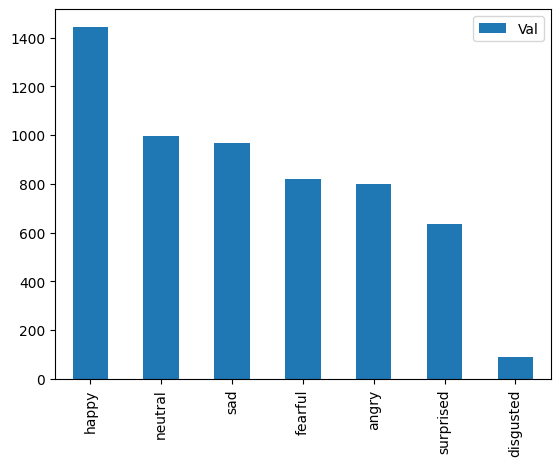

In [ ]:
val_count.plot(kind='bar')

In [ ]:
BATCH_SIZE = 8

train_dataloader = DataLoader(
    dataset=train_data,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=4
)

test_dataloader = DataLoader(
    dataset=test_data,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=4
)

val_dataloader = DataLoader(
    dataset=val_data,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=4
)

image_batch, label_batch = next(iter(train_dataloader))
image_batch.shape, label_batch.shape

(torch.Size([8, 3, 224, 224]), torch.Size([8]))

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

# Обучение моделей

## EfficientNet

In [ ]:
BATCH_SIZE = 16
model = torchvision.models.efficientnet_b0().to(device)

summary(
    model=model,
    input_size=(BATCH_SIZE, 3, 224, 224),
    col_names=["input_size", "output_size", "num_params", "trainable"],
    col_width=20,
    row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [16, 3, 224, 224]    [16, 1000]           --                   True
├─Sequential (features)                                      [16, 3, 224, 224]    [16, 1280, 7, 7]     --                   True
│    └─Conv2dNormActivation (0)                              [16, 3, 224, 224]    [16, 32, 112, 112]   --                   True
│    │    └─Conv2d (0)                                       [16, 3, 224, 224]    [16, 32, 112, 112]   864                  True
│    │    └─BatchNorm2d (1)                                  [16, 32, 112, 112]   [16, 32, 112, 112]   64                   True
│    │    └─SiLU (2)                                         [16, 32, 112, 112]   [16, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [16, 32, 112, 112]   [16, 16, 112

In [ ]:
output_shape = len(val_data.classes)

model.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True),
    torch.nn.Linear(in_features=1280,
                    out_features=output_shape,
                    bias=True)).to(device)

summary(
    model=model,
    input_size=(BATCH_SIZE, 3, 224, 224),
    col_names=["input_size", "output_size", "num_params", "trainable"],
    col_width=20,
    row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [16, 3, 224, 224]    [16, 7]              --                   True
├─Sequential (features)                                      [16, 3, 224, 224]    [16, 1280, 7, 7]     --                   True
│    └─Conv2dNormActivation (0)                              [16, 3, 224, 224]    [16, 32, 112, 112]   --                   True
│    │    └─Conv2d (0)                                       [16, 3, 224, 224]    [16, 32, 112, 112]   864                  True
│    │    └─BatchNorm2d (1)                                  [16, 32, 112, 112]   [16, 32, 112, 112]   64                   True
│    │    └─SiLU (2)                                         [16, 32, 112, 112]   [16, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [16, 32, 112, 112]   [16, 16, 112

In [ ]:
def val_step(
    model: torch.nn.Module,
    dataloader: torch.utils.data.DataLoader,
    loss_fn: torch.nn.Module,
    device: torch.device) -> Tuple[float, float, torch.Tensor]:

    model.eval()
    val_loss, val_acc = 0, 0
    y_preds = []

    with torch.inference_mode():
        for batch, (X, y) in enumerate(dataloader):
            X, y = X.to(device), y.to(device)
            val_pred_logits = model(X)
            loss = loss_fn(val_pred_logits, y)
            val_loss += loss.item()

            val_pred_labels = torch.argmax(val_pred_logits, dim=1)
            val_acc += ((val_pred_labels == y).sum().item() / len(val_pred_labels))
            y_preds.append(val_pred_labels.cpu())

    val_loss = val_loss / len(dataloader)
    val_acc = val_acc / len(dataloader)

    y_pred_tensor = torch.cat(y_preds)

    return val_loss, val_acc, y_pred_tensor


def train(
    model: torch.nn.Module,
    train_dataloader: torch.utils.data.DataLoader,
    val_dataloader: torch.utils.data.DataLoader,
    optimizer: torch.optim.Optimizer,
    loss_fn: torch.nn.Module,
    epochs: int,
    device: torch.device) -> Tuple[Dict, torch.Tensor]:

    results = {"train_loss": [],
             "train_acc": [],
             "val_loss": [],
             "val_acc": []}
    loss_min = np.inf
    loss_min_last_change_counter = 0 # счетчик сколько шагов назад был изменен loss_min
    best_model_name = ".\\EmotionRec_ver4.pt"
    for epoch in tqdm(range(epochs)):
        if loss_min_last_change_counter >= 10:
            print("Тренировка не показывала улучшение 10 эпох подряд.\nРаняя остановка")
            break
        model.train()
        train_loss, train_acc = 0, 0

        for batch, (X, y) in enumerate(train_dataloader):
            X, y = X.to(device), y.to(device)
            y_pred = model(X)
            loss = loss_fn(y_pred, y)
            train_loss += loss.item()

            optimizer.zero_grad()

            loss.backward()

            optimizer.step()

            y_pred_class = torch.argmax(y_pred, dim=1)
            train_acc += (y_pred_class == y).sum().item() / len(y_pred)

        train_loss = train_loss / len(train_dataloader)
        train_acc = train_acc / len(train_dataloader)

        val_loss, val_acc, y_preds = val_step(
            model=model,
            dataloader=val_dataloader,
            loss_fn=loss_fn,
            device=device
        )

        print(f"Epoch: {epoch}, Train loss: {train_loss:.3f}, Train accuracy: {train_acc:.3f}, Validation loss: {val_loss:.3f}, Validation accuracy: {val_acc:.3f}")
        if val_loss < loss_min:
            loss_min = val_loss
            loss_min_last_change_counter = 0
            torch.save(model.state_dict(), best_model_name)
            print(f"\nМинимальная валидационная потеря {loss_min:.6f} на эпохе {epoch}/{epochs}")
            print(f'Модель сохранена с названием {best_model_name}\n')
        else:
            loss_min_last_change_counter +=1
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["val_loss"].append(val_loss)
        results["val_acc"].append(val_acc)

    return results, y_preds, best_model_name

In [ ]:
torch.cuda.manual_seed(42)
torch.manual_seed(42)

EPOCHS = 50

loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(
    params=model.parameters(),
    lr=0.01
)

model_results, preds, best_model_name = train(
    model=model,
    train_dataloader=train_dataloader,
    val_dataloader=val_dataloader,
    optimizer=optimizer,
    loss_fn=loss_fn,
    epochs=EPOCHS,
    device=device
)


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 0, Train loss: 1.825, Train accuracy: 0.236, Validation loss: 3.327, Validation accuracy: 0.226

Минимальная валидационная потеря 3.327129 на эпохе 0/50
Модель сохранена с названием .\EmotionRec_ver1.pt

Epoch: 1, Train loss: 1.789, Train accuracy: 0.255, Validation loss: 1.856, Validation accuracy: 0.282

Минимальная валидационная потеря 1.855594 на эпохе 1/50
Модель сохранена с названием .\EmotionRec_ver1.pt

Epoch: 2, Train loss: 1.705, Train accuracy: 0.307, Validation loss: 1.537, Validation accuracy: 0.405

Минимальная валидационная потеря 1.536668 на эпохе 2/50
Модель сохранена с названием .\EmotionRec_ver1.pt

Epoch: 3, Train loss: 1.593, Train accuracy: 0.368, Validation loss: 1.379, Validation accuracy: 0.463

Минимальная валидационная потеря 1.378724 на эпохе 3/50
Модель сохранена с названием .\EmotionRec_ver1.pt

Epoch: 4, Train loss: 1.506, Train accuracy: 0.415, Validation loss: 1.340, Validation accuracy: 0.490

Минимальная валидационная потеря 1.340394 на эпохе 4

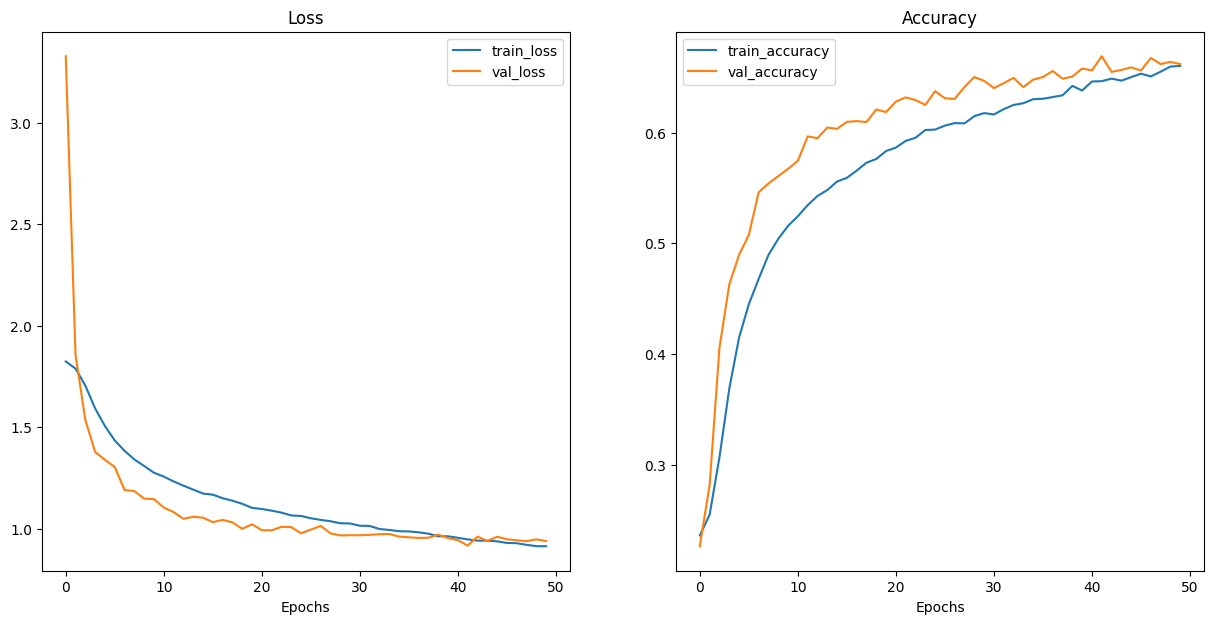

In [ ]:
def plot_curves(results: Dict[str, List[float]]) -> None:
    """Plots loss and accuracy from a results dictionary."""

    train_loss = results["train_loss"]
    val_loss = results["val_loss"]

    train_accuracy = results["train_acc"]
    val_accuracy = results["val_acc"]

    epochs = range(len(results["train_loss"]))

    plt.figure(figsize=(15, 7))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_loss, label="train_loss")
    plt.plot(epochs, val_loss, label="val_loss")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracy, label="train_accuracy")
    plt.plot(epochs, val_accuracy, label="val_accuracy")
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.legend()


plot_curves(model_results)

In [ ]:
model.load_state_dict(torch.load(best_model_name))
model.eval()

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [ ]:
torch.save(model, "EfficientNet.pt")

In [5]:
model = torch.load("EfficientNet.pt", weights_only= False).to(device)

### Оценка модели

In [ ]:
def make_predictions(model: torch.nn.Module,
                     data: list,
                     device: torch.device) -> torch.Tensor:

    pred_probs = []
    probabilities = []
    model.eval()


    with torch.inference_mode():
        for sample in data:
            sample = torch.unsqueeze(sample, dim=0).to(device)
            pred_logit = model(sample)
            pred_prob = torch.softmax(pred_logit.squeeze(), dim=0)
            pred_probs.append(pred_prob.cpu())
            probability = torch.softmax(pred_logit, dim=1)
            probabilities.append(probability.max())
    return torch.stack(pred_probs), torch.stack(probabilities)


def show_predictions(model: torch.nn.Module,
                     device: torch.device,
                     val_data: datasets) -> None:

    val_samples = []
    val_labels = []

    for sample, label in random.sample(list(val_data), k=9):
        val_samples.append(sample)
        val_labels.append(label)

    pred_probs, probabilities = make_predictions(
        model=model,
        data=val_samples,
        device=device
    )

    pred_classes = pred_probs.argmax(dim=1)
    plt.figure(figsize=(15, 9))
    nrows = 3
    ncols = 3
    for i, sample in enumerate(val_samples):
        plt.subplot(nrows, ncols, i+1)
        image = sample.squeeze().permute(1, 2, 0)
        plt.imshow(image)
        pred_label = val_data.classes[pred_classes[i]]
        truth_label = val_data.classes[val_labels[i]]
        title_text = f"Pred: {pred_label} | Truth: {truth_label} | {probabilities[i]:.2%} Уверенность"

        if pred_label == truth_label:
            plt.title(title_text, fontsize=10, c="g")
        else:
            plt.title(title_text, fontsize=10, c="r")
        plt.axis(False)

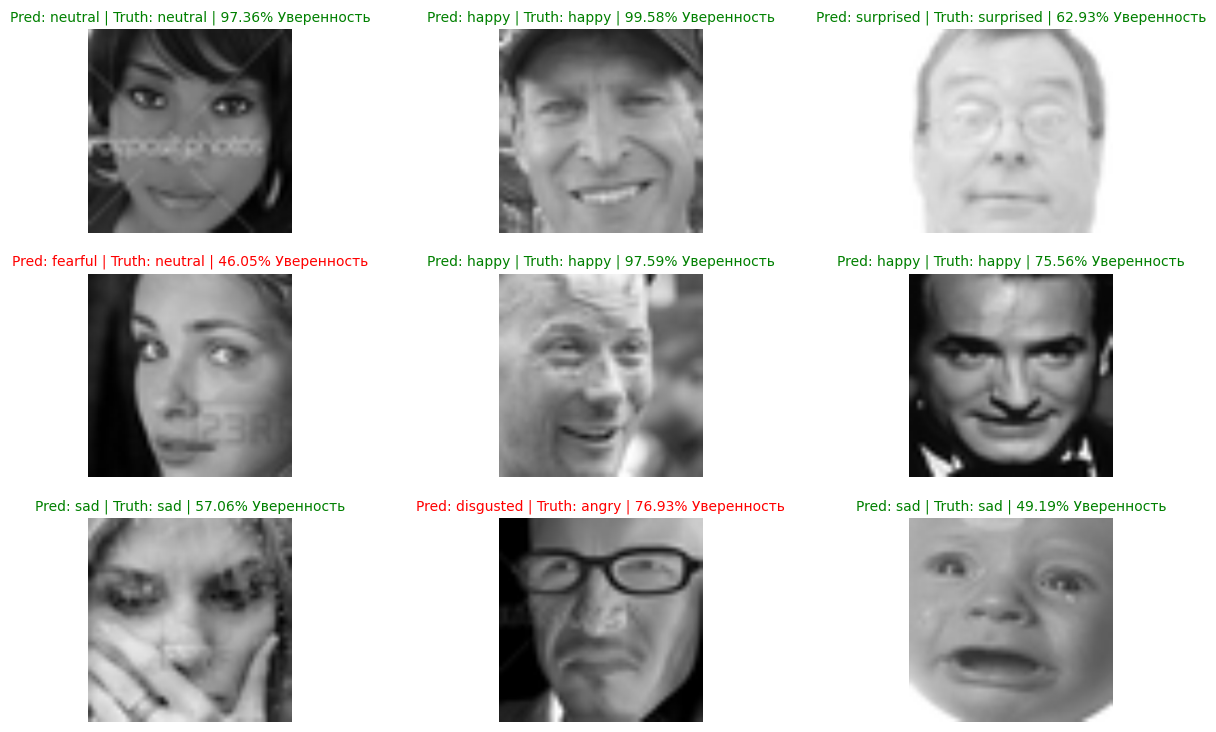

In [ ]:
show_predictions(
    model=model,
    val_data=test_data,
    device=device)

In [ ]:
loss_fn = nn.CrossEntropyLoss()

test_loss, test_acc, pred = val_step(
    model=model,
    dataloader=test_dataloader,
    loss_fn=loss_fn,
    device=device
)

print(f"Test loss: {test_loss:.3f}, Test accuracy: {test_acc:.3f}")

Test loss: 0.915, Test accuracy: 0.669


На валидационной выборке метрики качества были Validation loss: 0.918, Validation accuracy: 0.669.

Разница между оценками небольшая.

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

def conf_matrix_and_class_report(model, test_dataloader, test_data, device):
    model.eval()
    y_preds = []
    y_true = []

    with torch.inference_mode():
        for batch, (X, y) in enumerate(test_dataloader):
            X, y = X.to(device), y.to(device)
            val_pred_logits = model(X)
            val_pred_labels = torch.argmax(val_pred_logits, dim=1)
            y_preds.append(val_pred_labels.cpu())
            y_true.append(y)

    y_preds = torch.cat(y_preds)
    y_true = torch.cat(y_true)
    confusion = confusion_matrix(y_true, y_preds)

    plt.figure(figsize=(8, 6))
    sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=test_data.classes, yticklabels=test_data.classes)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.show()

    classification_rep = classification_report(y_true, y_preds, target_names=test_data.classes)
    print("Classification Report:\n", classification_rep)

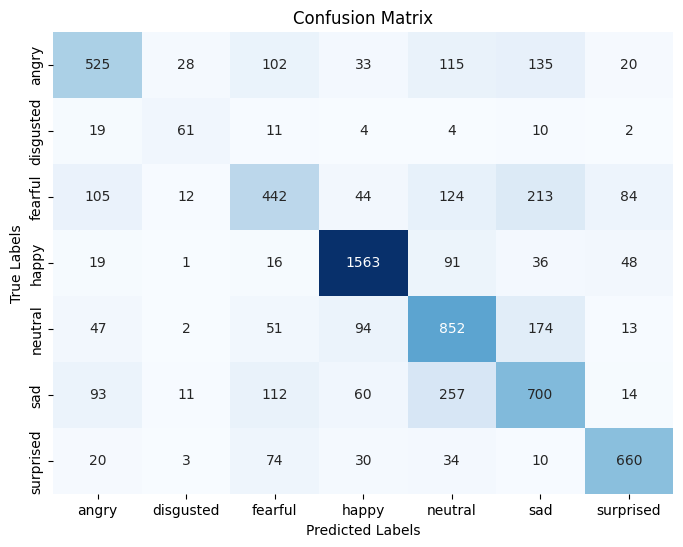

Classification Report:
               precision    recall  f1-score   support

       angry       0.63      0.55      0.59       958
   disgusted       0.52      0.55      0.53       111
     fearful       0.55      0.43      0.48      1024
       happy       0.86      0.88      0.87      1774
     neutral       0.58      0.69      0.63      1233
         sad       0.55      0.56      0.55      1247
   surprised       0.78      0.79      0.79       831

    accuracy                           0.67      7178
   macro avg       0.64      0.64      0.63      7178
weighted avg       0.67      0.67      0.67      7178



In [ ]:
conf_matrix_and_class_report(model, test_dataloader, test_data, device)

### Экспорт в формат ONNX

In [18]:
example_inputs = (torch.randn(1, 3, 224, 224),)

torch.onnx.export(model,
                  example_inputs,
                  "EfficientNet.onnx",
                  export_params=True,
                  opset_version=11,
                  do_constant_folding=True,
                  input_names=['input'],
                  output_names=['output'])

print("Модель успешно экспортирована в формат ONNX!")

Модель успешно экспортирована в формат ONNX!


### Работа модели с видео и вебкамерой

In [19]:
import PIL
import IPython
from io import BytesIO as StringIO

# отображает кадры видео в ноутбуке
def showframe(a, fmt="jpeg"):
    f = StringIO()
    PIL.Image.fromarray(a).save(f, fmt)
    IPython.display.display(IPython.display.Image(data=f.getvalue()))

In [20]:
face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml') # для детекции лиц на фото

In [ ]:
from torch.autograd import Variable
from IPython.display import clear_output
import json
import onnxruntime as ort
import onnx

emotions = ['angry', 'disgusted', 'fearful', 'happy', 'neutral', 'sad', 'surprised']


def plot_frames_and_predictions_onnx(frame, onnx_model, ort_session, scaleFactor=1.2, minNeighbors=7):
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    faces = face_cascade.detectMultiScale(frame, scaleFactor, minNeighbors)
    if len(faces) !=0:
        for (x,y,w,h) in faces:
            roi = frame[y:y+h, x:x+w]
            roi = cv2.cvtColor(roi, cv2.COLOR_BGR2RGB)
            roi =  roi/255.0
            roi = cv2.resize(roi, (224, 224))
            roi = np.array(roi).astype(np.float32)  # Преобразуем в float32
            roi = roi.transpose(2, 0, 1)  # Изменяем порядок осей на [C, H, W]
            input_roi = np.expand_dims(roi, axis=0)
            outputs = ort_session.run(None, {onnx_model.graph.input[0].name: input_roi})
            predicted_class = np.argmax(outputs[0])  # Получаем класс с максимальной вероятностью
            probability = torch.nn.functional.softmax(torch.from_numpy(outputs[0]), dim=-1)[0].max() # получаем вероятность класса
            title_text = f"Pred: {emotions[predicted_class]} | {probability:.2%}"
        for (x,y,w,h) in faces:
            cv2.rectangle(frame,(x,y),(x+w,y+h),(255,0,0))
        color = (255, 255, 255)
        thickness = 3
        cv2.putText(frame, title_text, (faces[0][0], faces[0][1] -10), cv2.FONT_HERSHEY_SIMPLEX, 1, color, thickness)
        
    showframe(frame)
    clear_output(wait=True)
    return cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)

In [ ]:
import cv2
from moviepy import ImageSequenceClip

onnx_model = onnx.load("EfficientNet.onnx")
ort_session = ort.InferenceSession("EfficientNet.onnx")
cap = cv2.VideoCapture("man_worried.mp4")
output_video = "video_output_EfficientNet.mp4"

if not cap.isOpened():
    print("Error: Could not open video file.")

frames = []
fps = int(cap.get(cv2.CAP_PROP_FPS))

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        print("Видео закончилось или появилась ошибка")
        break

    frames.append(cv2.cvtColor(plot_frames_and_predictions_onnx(frame, onnx_model,ort_session), cv2.COLOR_RGB2BGR))

cap.release()
clip = ImageSequenceClip(frames, fps=fps)
clip.write_videofile(output_video, codec='libx264')

Видео закончилось или появилась ошибка
MoviePy - Building video video_output_EfficientNet.mp4.
MoviePy - Writing video video_output_EfficientNet.mp4



frame_index:   0%|          | 0/74 [00:00<?, ?it/s, now=None]

MoviePy - Done !
MoviePy - video ready video_output_EfficientNet.mp4


In [ ]:
onnx_model = onnx.load("EfficientNet.onnx")
ort_session = ort.InferenceSession("EfficientNet.onnx")

cap = cv2.VideoCapture(0)
output_video = "webcam_output_EfficientNet.mp4"
frames = []
try:
    while True:

        ret, frame = cap.read()
        if not ret:
            print("Веб-камера отключена или появилась ошибка")
            break
        frame = cv2.flip(frame, 1) # переворачиваем видео веб-камеры для более приятного просмотра
        frames.append(cv2.cvtColor(plot_frames_and_predictions_onnx(frame, onnx_model,ort_session), cv2.COLOR_RGB2BGR))

except KeyboardInterrupt:
    cap.release()
    clip = ImageSequenceClip(frames, fps=20)
    clip.write_videofile(output_video, codec='libx264')
    print("Веб-камера отключена")

MoviePy - Building video webcam_output_EfficientNet.mp4.
MoviePy - Writing video webcam_output_EfficientNet.mp4



MoviePy - Done !
MoviePy - video ready webcam_output_EfficientNet.mp4
Веб-камера отключена


## ResNet18

In [ ]:
BATCH_SIZE = 16
model = torchvision.models.resnet18(pretrained=True).to(device)

summary(
    model=model,
    input_size=(BATCH_SIZE, 3, 224, 224),
    col_names=["input_size", "output_size", "num_params", "trainable"],
    col_width=20,
    row_settings=["var_names"]
)

c:\Users\Пользователь\AppData\Local\Programs\Python\Python313\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Пользователь\AppData\Local\Programs\Python\Python313\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
ResNet (ResNet)                          [16, 3, 224, 224]    [16, 1000]           --                   True
├─Conv2d (conv1)                         [16, 3, 224, 224]    [16, 64, 112, 112]   9,408                True
├─BatchNorm2d (bn1)                      [16, 64, 112, 112]   [16, 64, 112, 112]   128                  True
├─ReLU (relu)                            [16, 64, 112, 112]   [16, 64, 112, 112]   --                   --
├─MaxPool2d (maxpool)                    [16, 64, 112, 112]   [16, 64, 56, 56]     --                   --
├─Sequential (layer1)                    [16, 64, 56, 56]     [16, 64, 56, 56]     --                   True
│    └─BasicBlock (0)                    [16, 64, 56, 56]     [16, 64, 56, 56]     --                   True
│    │    └─Conv2d (conv1)               [16, 64, 56, 56]     [16, 64, 56, 56]     36,864               True
│    │    └─BatchN

In [ ]:
output_shape = len(val_data.classes)

model.fc = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True),
    torch.nn.Linear(in_features=512,
                    out_features=output_shape,
                    bias=True)).to(device)

summary(
    model=model,
    input_size=(BATCH_SIZE, 3, 224, 224),
    col_names=["input_size", "output_size", "num_params", "trainable"],
    col_width=20,
    row_settings=["var_names"]
)

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
ResNet (ResNet)                          [16, 3, 224, 224]    [16, 7]              --                   True
├─Conv2d (conv1)                         [16, 3, 224, 224]    [16, 64, 112, 112]   9,408                True
├─BatchNorm2d (bn1)                      [16, 64, 112, 112]   [16, 64, 112, 112]   128                  True
├─ReLU (relu)                            [16, 64, 112, 112]   [16, 64, 112, 112]   --                   --
├─MaxPool2d (maxpool)                    [16, 64, 112, 112]   [16, 64, 56, 56]     --                   --
├─Sequential (layer1)                    [16, 64, 56, 56]     [16, 64, 56, 56]     --                   True
│    └─BasicBlock (0)                    [16, 64, 56, 56]     [16, 64, 56, 56]     --                   True
│    │    └─Conv2d (conv1)               [16, 64, 56, 56]     [16, 64, 56, 56]     36,864               True
│    │    └─BatchN

In [ ]:
torch.cuda.manual_seed(42)
torch.manual_seed(42)

EPOCHS = 50

loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(
    params=model.parameters(),
    lr=0.01
)

model_results, preds, best_model_name = train(
    model=model,
    train_dataloader=train_dataloader,
    val_dataloader=val_dataloader,
    optimizer=optimizer,
    loss_fn=loss_fn,
    epochs=EPOCHS,
    device=device
)

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 0, Train loss: 1.674, Train accuracy: 0.366, Validation loss: 1.686, Validation accuracy: 0.407

Минимальная валидационная потеря 1.686343 на эпохе 0/50
Модель сохранена с названием .\EmotionRec_ver4.pt

Epoch: 1, Train loss: 1.422, Train accuracy: 0.457, Validation loss: 1.452, Validation accuracy: 0.455

Минимальная валидационная потеря 1.451920 на эпохе 1/50
Модель сохранена с названием .\EmotionRec_ver4.pt

Epoch: 2, Train loss: 1.324, Train accuracy: 0.498, Validation loss: 1.566, Validation accuracy: 0.426
Epoch: 3, Train loss: 1.275, Train accuracy: 0.517, Validation loss: 1.310, Validation accuracy: 0.505

Минимальная валидационная потеря 1.310456 на эпохе 3/50
Модель сохранена с названием .\EmotionRec_ver4.pt

Epoch: 4, Train loss: 1.231, Train accuracy: 0.536, Validation loss: 1.470, Validation accuracy: 0.449
Epoch: 5, Train loss: 1.207, Train accuracy: 0.549, Validation loss: 1.181, Validation accuracy: 0.563

Минимальная валидационная потеря 1.181212 на эпохе 5/50
М

In [ ]:
model.load_state_dict(torch.load(best_model_name))
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
torch.save(model, "ResNet18.pt")

In [95]:
model = torch.load("ResNet18.pt", weights_only=False).to(device)

### Оценка модели

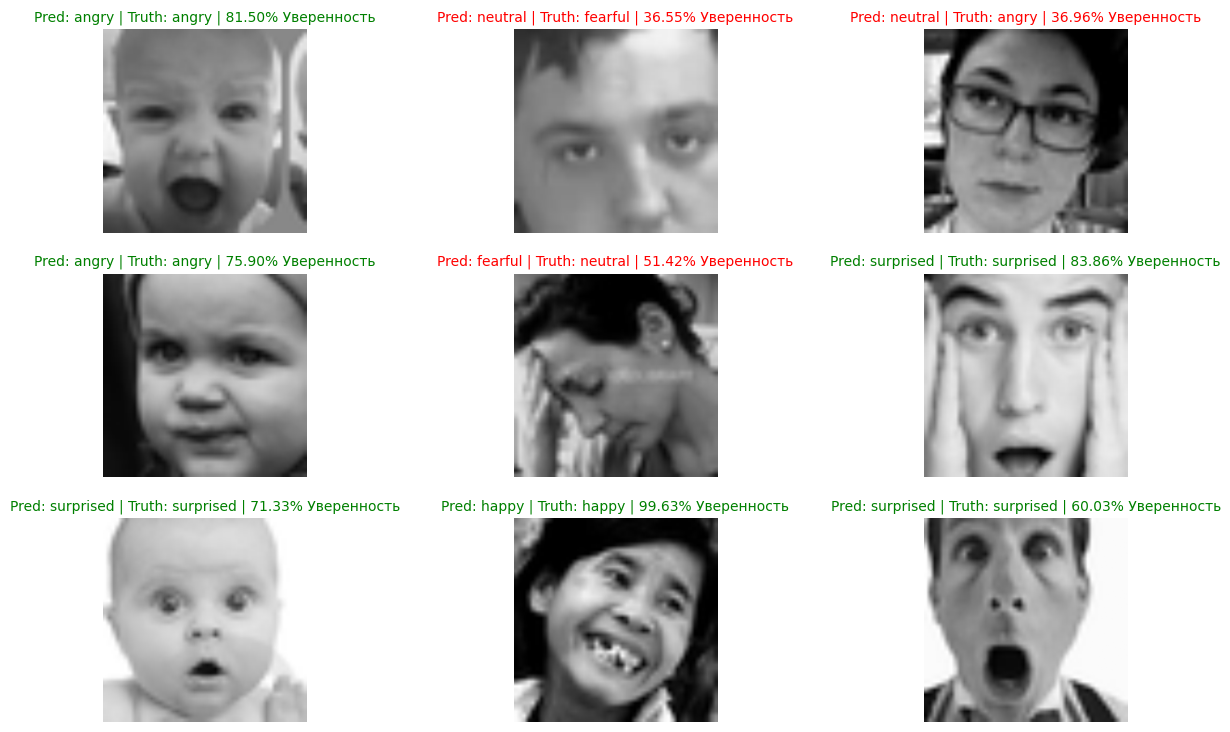

In [ ]:
show_predictions(
    model=model,
    val_data=test_data,
    device=device)

In [ ]:
loss_fn = nn.CrossEntropyLoss()

test_loss, test_acc, pred = val_step(
    model=model,
    dataloader=test_dataloader,
    loss_fn=loss_fn,
    device=device
)

print(f"Test loss: {test_loss:.3f}, Test accuracy: {test_acc:.3f}")

Test loss: 1.023, Test accuracy: 0.620


На валидационной выборке метрики качества были Validation loss: 1.023, Validation accuracy: 0.617.

Разница между оценками небольшая.

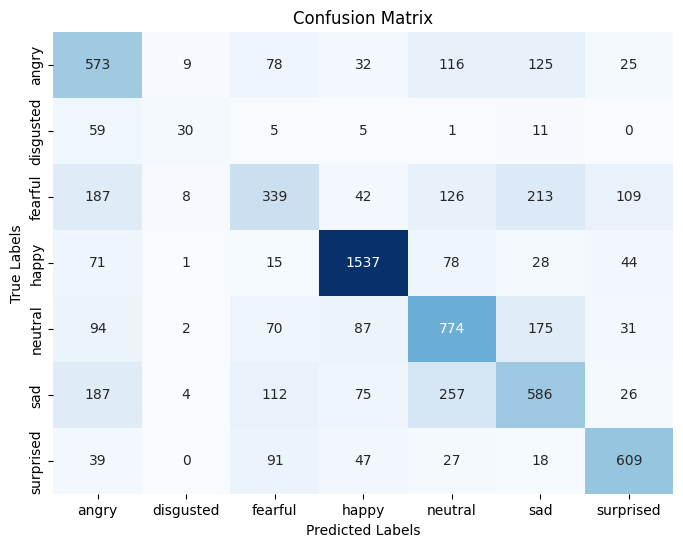

Classification Report:
               precision    recall  f1-score   support

       angry       0.47      0.60      0.53       958
   disgusted       0.56      0.27      0.36       111
     fearful       0.48      0.33      0.39      1024
       happy       0.84      0.87      0.85      1774
     neutral       0.56      0.63      0.59      1233
         sad       0.51      0.47      0.49      1247
   surprised       0.72      0.73      0.73       831

    accuracy                           0.62      7178
   macro avg       0.59      0.56      0.56      7178
weighted avg       0.62      0.62      0.61      7178



In [ ]:
conf_matrix_and_class_report(model, test_dataloader, test_data, device)

### Экспорт в формат ONNX

In [96]:
example_inputs = (torch.randn(1, 3, 224, 224),)

torch.onnx.export(model,
                  example_inputs,
                  "ResNet18.onnx",
                  export_params=True,
                  opset_version=11,
                  do_constant_folding=True,
                  input_names=['input'],
                  output_names=['output'])

print("Модель успешно экспортирована в формат ONNX!")

Модель успешно экспортирована в формат ONNX!


### Работа модели с видео и вебкамерой

In [ ]:
import cv2
from moviepy import ImageSequenceClip

onnx_model = onnx.load("ResNet18.onnx")
ort_session = ort.InferenceSession("ResNet18.onnx")

cap = cv2.VideoCapture("man_worried.mp4")
output_video = "video_output_ResNet18.mp4"

if not cap.isOpened():
    print("Error: Could not open video file.")

frames = []
fps = int(cap.get(cv2.CAP_PROP_FPS))

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        print("Видео закончилось или появилась ошибка")
        break

    frames.append(cv2.cvtColor(plot_frames_and_predictions_onnx(frame, onnx_model, ort_session), cv2.COLOR_RGB2BGR))

cap.release()
clip = ImageSequenceClip(frames, fps=fps)
clip.write_videofile(output_video, codec='libx264')

Видео закончилось или появилась ошибка
MoviePy - Building video video_output_ResNet18.mp4.
MoviePy - Writing video video_output_ResNet18.mp4



MoviePy - Done !
MoviePy - video ready video_output_ResNet18.mp4


In [ ]:
onnx_model = onnx.load("ResNet18.onnx")
ort_session = ort.InferenceSession("ResNet18.onnx")

cap = cv2.VideoCapture(0)
output_video = "webcam_output_ResNet18.mp4"
frames = []
try:
    while True:

        ret, frame = cap.read()

        frame = cv2.flip(frame, 1) # переворачиваем видео веб-камеры для более приятного просмотра
        frames.append(cv2.cvtColor(plot_frames_and_predictions_onnx(frame, onnx_model, ort_session), cv2.COLOR_RGB2BGR))

except KeyboardInterrupt:
    cap.release()
    clip = ImageSequenceClip(frames, fps=20)
    clip.write_videofile(output_video, codec='libx264')
    print("Веб-камера отключена")

MoviePy - Building video webcam_output_ResNet18.mp4.
MoviePy - Writing video webcam_output_ResNet18.mp4



MoviePy - Done !
MoviePy - video ready webcam_output_ResNet18.mp4
Веб-камера отключена


## Yolo

In [ ]:
train_path = images_path / "train"
validation_path = images_path / "validation"
test_path = images_path / "test"
class_names = ['angry', 'disgusted', 'fearful', 'happy', 'neutral', 'sad', 'surprised']


for path in [train_path, validation_path, test_path]:
    yolo_images = path / "images"
    yolo_labels = path / "labels"
    for dir_name in class_names:
        file_count = 0
        dir_path = path / dir_name
        for root, dir, files in os.walk(dir_path):
            for file in files:
                if file_count >= 1500 and path == train_path:
                    break
                if not os.path.exists(yolo_images):
                    os.makedirs(yolo_images)
                if not os.path.exists(yolo_labels):
                    os.makedirs(yolo_labels)
                file_count +=1
                shutil.copy(os.path.join(root, file), yolo_images / f"{dir_name}_{file}")
                label_file = open(yolo_labels / f"{dir_name}_{os.path.splitext(file)[0]}.txt", "w+")
                label_file.write(f"{class_names.index(dir_name)} 0.48 0.48 1.0 1.0")
                label_file.close()


In [ ]:
import yaml

class_names = ['angry', 'disgusted', 'fearful', 'happy', 'neutral', 'sad', 'surprised']
data = {
    'train': "../emotions_dataset/train/images",
    'val': "../emotions_dataset/validation/images",
    'test' : "../emotions_dataset/test/images",
    'nc': len(class_names),
    'names': {i: name for i, name in enumerate(class_names)}
}

yaml_file = "dataset.yaml"
with open(yaml_file, 'w') as file:
    yaml.dump(data, file, default_flow_style=False)

with open(yaml_file, 'r') as file:
    lines = file.readlines()
    print(lines)

['names:\n', '  0: angry\n', '  1: disgusted\n', '  2: fearful\n', '  3: happy\n', '  4: neutral\n', '  5: sad\n', '  6: surprised\n', 'nc: 7\n', 'test: ../emotions_dataset/test/images\n', 'train: ../emotions_dataset/train/images\n', 'val: ../emotions_dataset/validation/images\n']


In [ ]:
from ultralytics import YOLO

model = YOLO("yolo11n.pt")

In [ ]:
def plot_images_with_bboxes(samples, images_dir, labels_dir, class_names):
    fig, axes = plt.subplots(nrows=len(samples), ncols=1, figsize=(8, 16))

    for idx, sample in enumerate(samples):
        img_path = os.path.join(images_dir, sample[0])
        label_path = os.path.join(labels_dir, sample[1])
        image = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)

        if os.path.exists(label_path):
            with open(label_path, 'r') as file:
                for line in file:
                    class_id, x, y, w, h = map(float, line.split())
                    h_img, w_img, _ = image.shape
                    x, y, w, h = x * w_img, y * h_img, w * w_img, h * h_img
                    x_min, y_min = int(x - w / 2), int(y - h / 2)
                    x_max, y_max = int(x + w / 2), int(y + h / 2)

                    cv2.rectangle(image, (x_min, y_min), (x_max, y_max), (0, 0, 255), 1)
                    cv2.putText(image, class_names[int(class_id)], (x_min, max(y_min - 10, 10)),
                                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

        plt.imshow(image)
        plt.axis('off')

    plt.tight_layout()
    plt.show()

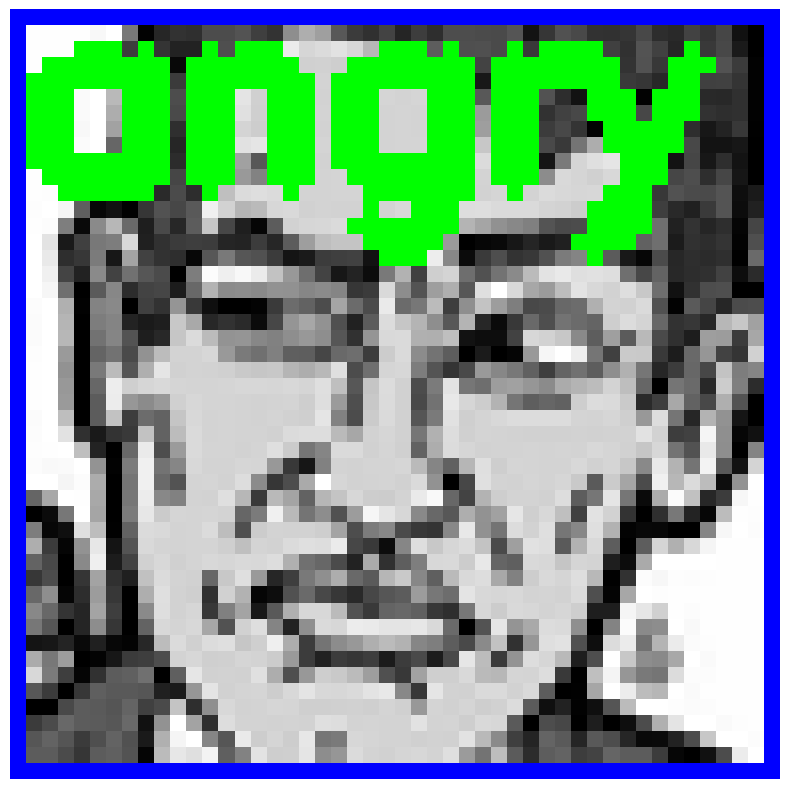

In [ ]:
class_names = ['angry', 'disgusted', 'fearful', 'happy', 'neutral', 'sad', 'surprised']

plot_images_with_bboxes([["angry_im0.png", "angry_im0.txt"]], "emotions_dataset\\test\\images", "emotions_dataset\\test\\labels", class_names)

Подбираем лучшие гиперпараметры

In [ ]:
search_space = {
    "lr0": (1e-5, 1e-1),
    "degrees": (0.0, 90.0),
    "hsv_h" : (0.0, 0.1),
    "hsv_s" : (0.0, 0.9),
    "hsv_v" : (0.0, 0.9),
    "mosaic" : (0.0, 0.0),
    "fliplr": (0.0, 1.0),
    "mixup": (0.0 , 0.0),
    "copy_paste": (0.0, 0.0),
    "scale" : (0.0, 0.9)
}

results = model.tune(
    data="dataset.yaml",
    epochs=3,
    iterations=20,
    optimizer="AdamW",
    space=search_space,
    plots=False,
    save=False,
    val=False,
)
print(results)

Tuner: Initialized Tuner instance with 'tune_dir=runs\detect\tune4'
Tuner:  Learn about tuning at https://docs.ultralytics.com/guides/hyperparameter-tuning
Tuner: Starting iteration 1/20 with hyperparameters: {'lr0': 0.01, 'degrees': 0.0, 'hsv_h': 0.015, 'hsv_s': 0.7, 'hsv_v': 0.4, 'mosaic': 0.0, 'fliplr': 0.5, 'mixup': 0.0, 'copy_paste': 0.0, 'scale': 0.5}
Saved runs\detect\tune4\tune_scatter_plots.png
Saved runs\detect\tune4\tune_fitness.png

Tuner: 1/20 iterations complete  (3761.95s)
Tuner: Results saved to runs\detect\tune4
Tuner: Best fitness=0.14929 observed at iteration 1
Tuner: Best fitness metrics are {'metrics/precision(B)': 0.14283, 'metrics/recall(B)': 1.0, 'metrics/mAP50(B)': 0.14957, 'metrics/mAP50-95(B)': 0.14926, 'val/box_loss': 0.50151, 'val/cls_loss': 1.44914, 'val/dfl_loss': 2.1737, 'fitness': 0.14929}
Tuner: Best fitness model is runs\detect\train15
Tuner: Best fitness hyperparameters are printed below.

Printing 'runs\detect\tune4\best_hyperparameters.yaml'

lr0: 

In [ ]:
train_results = model.train(
    data="dataset.yaml",
    epochs=100,
    imgsz=640,
    device="cpu",
    cfg = "runs\\detect\\tune4\\best_hyperparameters.yaml",
    patience = 10
)

New https://pypi.org/project/ultralytics/8.3.161 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.40  Python-3.13.2 torch-2.7.1+cpu CPU (12th Gen Intel Core(TM) i5-12450H)
engine\trainer: task=detect, mode=train, model=yolo11n.pt, data=dataset.yaml, epochs=100, time=None, patience=10, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=cpu, workers=8, project=None, name=train35, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False

train: Scanning C:\Users\Public\EmotionRecognition\emotions_dataset\train\labels.cache... 9348 images, 0 backgrounds, 0 corrupt: 100%|██████████| 9348/9348 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))



c:\Users\Пользователь\AppData\Local\Programs\Python\Python313\Lib\site-packages\ultralytics\data\augment.py:1850: UserWarning: Argument(s) 'quality_lower' are not valid for transform ImageCompression
  A.ImageCompression(quality_lower=75, p=0.0),
c:\Users\Пользователь\AppData\Local\Programs\Python\Python313\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
val: Scanning C:\Users\Public\EmotionRecognition\emotions_dataset\validation\labels.cache... 5748 images, 0 backgrounds, 0 corrupt: 100%|██████████| 5748/5748 [00:00<?, ?it/s]

Plotting labels to runs\detect\train35\labels.jpg... 


optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: SGD(lr=0.01, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to runs\detect\train35
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100         0G     0.3605      2.956      1.169          4        640: 100%|██████████| 585/585 [24:39<00:00,  2.53s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 180/180 [06:08<00:00,  2.05s/it]


                   all       5748       5748      0.315      0.752      0.256      0.244

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100         0G     0.2502      1.858      1.069          4        640: 100%|██████████| 585/585 [25:37<00:00,  2.63s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 180/180 [11:19<00:00,  3.77s/it]

                   all       5748       5748      0.328      0.677       0.31      0.294



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100         0G      0.254      1.523      1.074          4        640: 100%|██████████| 585/585 [34:58<00:00,  3.59s/it]  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 180/180 [06:08<00:00,  2.04s/it]

                   all       5748       5748      0.376      0.634       0.28      0.267



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100         0G     0.2423      1.397      1.068          4        640: 100%|██████████| 585/585 [24:22<00:00,  2.50s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 180/180 [05:39<00:00,  1.89s/it]

                   all       5748       5748      0.407      0.666      0.333      0.312



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100         0G     0.2236      1.318      1.047          4        640: 100%|██████████| 585/585 [24:25<00:00,  2.50s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 180/180 [05:43<00:00,  1.91s/it]

                   all       5748       5748      0.358      0.687      0.307      0.283



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100         0G     0.2092      1.265      1.038          4        640: 100%|██████████| 585/585 [24:25<00:00,  2.50s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 180/180 [05:38<00:00,  1.88s/it]

                   all       5748       5748      0.395      0.587      0.292      0.275



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100         0G     0.2081      1.247      1.032          4        640: 100%|██████████| 585/585 [24:23<00:00,  2.50s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 180/180 [05:35<00:00,  1.86s/it]

                   all       5748       5748      0.313      0.658      0.397      0.381



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100         0G     0.1982      1.218      1.024          4        640: 100%|██████████| 585/585 [32:38<00:00,  3.35s/it] 
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 180/180 [05:34<00:00,  1.86s/it]

                   all       5748       5748      0.438      0.585      0.393      0.376



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100         0G     0.1962      1.204      1.025          4        640: 100%|██████████| 585/585 [24:22<00:00,  2.50s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 180/180 [05:33<00:00,  1.86s/it]

                   all       5748       5748      0.466      0.609      0.407       0.39



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100         0G     0.1933       1.18       1.02          4        640: 100%|██████████| 585/585 [1:05:06<00:00,  6.68s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 180/180 [14:04<00:00,  4.69s/it]

                   all       5748       5748      0.468      0.626      0.419      0.401



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100         0G     0.1905      1.172      1.019          4        640: 100%|██████████| 585/585 [36:12<00:00,  3.71s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 180/180 [18:47<00:00,  6.26s/it]

                   all       5748       5748      0.354      0.626      0.423      0.395



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100         0G     0.1892       1.15      1.016          4        640: 100%|██████████| 585/585 [56:25<00:00,  5.79s/it]  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 180/180 [05:42<00:00,  1.90s/it]

                   all       5748       5748      0.312      0.622      0.434      0.419



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100         0G     0.1878      1.139      1.016          4        640: 100%|██████████| 585/585 [29:29<00:00,  3.02s/it] 
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 180/180 [06:17<00:00,  2.10s/it]

                   all       5748       5748      0.491      0.647      0.458      0.427



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100         0G     0.1875      1.124      1.012          4        640: 100%|██████████| 585/585 [27:56<00:00,  2.87s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 180/180 [05:36<00:00,  1.87s/it]

                   all       5748       5748      0.367      0.689      0.464      0.441



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100         0G     0.1853      1.116      1.012          4        640: 100%|██████████| 585/585 [24:26<00:00,  2.51s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 180/180 [05:34<00:00,  1.86s/it]

                   all       5748       5748      0.509      0.597       0.47      0.444



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100         0G     0.1843        1.1      1.011          4        640: 100%|██████████| 585/585 [24:24<00:00,  2.50s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 180/180 [05:34<00:00,  1.86s/it]

                   all       5748       5748      0.352      0.666      0.464      0.443



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100         0G     0.1818      1.093      1.009          4        640: 100%|██████████| 585/585 [24:25<00:00,  2.50s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 180/180 [05:34<00:00,  1.86s/it]

                   all       5748       5748      0.393      0.637      0.465      0.455



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100         0G       0.18      1.093      1.007          4        640: 100%|██████████| 585/585 [24:25<00:00,  2.50s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 180/180 [05:37<00:00,  1.87s/it]

                   all       5748       5748      0.403      0.639      0.491      0.476



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100         0G     0.1804      1.071      1.008          4        640: 100%|██████████| 585/585 [24:21<00:00,  2.50s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 180/180 [05:33<00:00,  1.86s/it]

                   all       5748       5748      0.402      0.618      0.457       0.44



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100         0G       0.18      1.069      1.007          4        640: 100%|██████████| 585/585 [24:22<00:00,  2.50s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 180/180 [05:34<00:00,  1.86s/it]

                   all       5748       5748      0.423      0.616      0.501      0.497



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100         0G     0.1764      1.054      1.006          4        640: 100%|██████████| 585/585 [24:24<00:00,  2.50s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 180/180 [05:34<00:00,  1.86s/it]

                   all       5748       5748      0.418      0.653      0.503      0.496



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100         0G     0.1783      1.056      1.006          4        640: 100%|██████████| 585/585 [24:22<00:00,  2.50s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 180/180 [05:38<00:00,  1.88s/it]

                   all       5748       5748      0.411      0.647      0.504      0.488



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100         0G     0.1789      1.048      1.004          4        640: 100%|██████████| 585/585 [24:23<00:00,  2.50s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 180/180 [05:33<00:00,  1.85s/it]

                   all       5748       5748      0.418      0.654      0.515      0.493



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100         0G     0.1774      1.037      1.005          4        640: 100%|██████████| 585/585 [24:21<00:00,  2.50s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 180/180 [05:33<00:00,  1.86s/it]

                   all       5748       5748      0.411      0.591      0.467      0.454



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100         0G     0.1749      1.027      1.004          4        640: 100%|██████████| 585/585 [24:22<00:00,  2.50s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 180/180 [05:34<00:00,  1.86s/it]

                   all       5748       5748      0.459      0.616       0.53      0.519



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100         0G     0.1766      1.022      1.004          4        640: 100%|██████████| 585/585 [24:23<00:00,  2.50s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 180/180 [05:37<00:00,  1.87s/it]

                   all       5748       5748      0.443      0.636      0.511      0.507



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100         0G     0.1765      1.015      1.001          4        640: 100%|██████████| 585/585 [24:22<00:00,  2.50s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 180/180 [05:34<00:00,  1.86s/it]

                   all       5748       5748      0.436      0.622      0.503        0.5



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100         0G     0.1736      1.011      1.001          4        640: 100%|██████████| 585/585 [24:18<00:00,  2.49s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 180/180 [05:33<00:00,  1.85s/it]

                   all       5748       5748      0.444      0.663      0.528       0.52



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100         0G     0.1728      1.002      1.004          4        640: 100%|██████████| 585/585 [24:19<00:00,  2.49s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 180/180 [05:34<00:00,  1.86s/it]

                   all       5748       5748       0.44      0.633      0.535      0.524



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100         0G     0.1729     0.9887      1.002          4        640: 100%|██████████| 585/585 [24:21<00:00,  2.50s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 180/180 [05:36<00:00,  1.87s/it]

                   all       5748       5748      0.445      0.647      0.541      0.537



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100         0G     0.1739      0.993      1.003          4        640: 100%|██████████| 585/585 [24:23<00:00,  2.50s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 180/180 [05:34<00:00,  1.86s/it]

                   all       5748       5748      0.483      0.638      0.556       0.54



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100         0G     0.1722     0.9812          1          4        640: 100%|██████████| 585/585 [24:24<00:00,  2.50s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 180/180 [05:34<00:00,  1.86s/it]

                   all       5748       5748      0.487      0.631       0.56      0.553



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100         0G     0.1722     0.9762     0.9997          4        640: 100%|██████████| 585/585 [24:48<00:00,  2.54s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 180/180 [05:35<00:00,  1.86s/it]

                   all       5748       5748      0.502      0.612      0.563      0.562



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100         0G       0.17     0.9691      1.001          4        640: 100%|██████████| 585/585 [24:26<00:00,  2.51s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 180/180 [05:37<00:00,  1.87s/it]

                   all       5748       5748      0.495      0.642      0.561      0.543



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100         0G     0.1705     0.9679      1.001          4        640: 100%|██████████| 585/585 [24:26<00:00,  2.51s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 180/180 [05:35<00:00,  1.86s/it]

                   all       5748       5748      0.496      0.622      0.574      0.566



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100         0G     0.1715     0.9584     0.9973          4        640: 100%|██████████| 585/585 [24:28<00:00,  2.51s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 180/180 [05:36<00:00,  1.87s/it]

                   all       5748       5748      0.483      0.655      0.569      0.565



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100         0G      0.169     0.9494     0.9976          4        640: 100%|██████████| 585/585 [24:27<00:00,  2.51s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 180/180 [05:35<00:00,  1.86s/it]

                   all       5748       5748      0.518      0.643      0.585      0.571



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100         0G     0.1705     0.9456     0.9996          4        640: 100%|██████████| 585/585 [24:23<00:00,  2.50s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 180/180 [05:37<00:00,  1.87s/it]

                   all       5748       5748      0.517       0.63      0.587      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100         0G     0.1696     0.9467     0.9981          4        640: 100%|██████████| 585/585 [24:24<00:00,  2.50s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 180/180 [05:34<00:00,  1.86s/it]

                   all       5748       5748      0.533       0.62      0.593      0.585



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100         0G     0.1689     0.9292     0.9989          4        640: 100%|██████████| 585/585 [24:26<00:00,  2.51s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 180/180 [05:34<00:00,  1.86s/it]

                   all       5748       5748      0.532       0.64      0.603      0.602



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100         0G     0.1685     0.9259     0.9987          4        640: 100%|██████████| 585/585 [24:25<00:00,  2.51s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 180/180 [05:34<00:00,  1.86s/it]

                   all       5748       5748      0.525      0.648      0.602      0.598



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100         0G      0.167     0.9118     0.9981          4        640: 100%|██████████| 585/585 [24:30<00:00,  2.51s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 180/180 [05:36<00:00,  1.87s/it]

                   all       5748       5748       0.52      0.649      0.605      0.602



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100         0G      0.168     0.9068     0.9962          4        640: 100%|██████████| 585/585 [24:28<00:00,  2.51s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 180/180 [05:34<00:00,  1.86s/it]

                   all       5748       5748      0.539      0.657      0.607      0.593



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100         0G     0.1677     0.9073     0.9981          4        640: 100%|██████████| 585/585 [24:24<00:00,  2.50s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 180/180 [05:34<00:00,  1.86s/it]

                   all       5748       5748      0.533       0.66      0.614      0.606



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100         0G      0.168     0.8905     0.9969          4        640: 100%|██████████| 585/585 [24:25<00:00,  2.51s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 180/180 [05:34<00:00,  1.86s/it]

                   all       5748       5748      0.523      0.668      0.611      0.603



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100         0G     0.1666     0.8899     0.9986          4        640: 100%|██████████| 585/585 [24:25<00:00,  2.51s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 180/180 [05:37<00:00,  1.87s/it]

                   all       5748       5748      0.515      0.675      0.619      0.615



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100         0G     0.1648     0.8838      0.998          4        640: 100%|██████████| 585/585 [24:35<00:00,  2.52s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 180/180 [05:34<00:00,  1.86s/it]

                   all       5748       5748      0.539      0.663      0.626      0.619



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100         0G     0.1657     0.8771     0.9967          4        640: 100%|██████████| 585/585 [24:34<00:00,  2.52s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 180/180 [05:35<00:00,  1.86s/it]

                   all       5748       5748      0.555      0.661      0.624      0.617



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100         0G      0.166     0.8649     0.9975          4        640: 100%|██████████| 585/585 [24:27<00:00,  2.51s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 180/180 [05:36<00:00,  1.87s/it]

                   all       5748       5748       0.54      0.675      0.618      0.609



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100         0G     0.1665     0.8571     0.9965          4        640: 100%|██████████| 585/585 [24:24<00:00,  2.50s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 180/180 [05:37<00:00,  1.87s/it]

                   all       5748       5748      0.549      0.673      0.632      0.629



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100         0G     0.1645     0.8502     0.9964          4        640: 100%|██████████| 585/585 [24:25<00:00,  2.51s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 180/180 [05:35<00:00,  1.86s/it]

                   all       5748       5748      0.567      0.661      0.636      0.634



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100         0G     0.1661     0.8455     0.9965          4        640: 100%|██████████| 585/585 [24:25<00:00,  2.50s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 180/180 [05:35<00:00,  1.86s/it]

                   all       5748       5748      0.565      0.657      0.638      0.637



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100         0G     0.1648     0.8325     0.9945          4        640: 100%|██████████| 585/585 [24:22<00:00,  2.50s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 180/180 [05:35<00:00,  1.87s/it]

                   all       5748       5748      0.573      0.657      0.647      0.644



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100         0G     0.1683     0.8253     0.9918          4        640: 100%|██████████| 585/585 [24:24<00:00,  2.50s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 180/180 [05:40<00:00,  1.89s/it]

                   all       5748       5748      0.551      0.681      0.644      0.641



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100         0G     0.1667       0.82     0.9949          4        640: 100%|██████████| 585/585 [1:09:41<00:00,  7.15s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 180/180 [17:24<00:00,  5.80s/it]

                   all       5748       5748      0.567      0.663      0.644      0.635



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100         0G     0.1647     0.8077     0.9952          4        640: 100%|██████████| 585/585 [1:10:52<00:00,  7.27s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 180/180 [05:40<00:00,  1.89s/it]

                   all       5748       5748       0.58      0.648      0.646      0.645



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100         0G     0.1645     0.8046     0.9949          4        640: 100%|██████████| 585/585 [29:44<00:00,  3.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 180/180 [06:25<00:00,  2.14s/it]

                   all       5748       5748      0.572      0.667      0.646      0.638



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100         0G     0.1652     0.7964      0.995          4        640: 100%|██████████| 585/585 [26:27<00:00,  2.71s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 180/180 [05:37<00:00,  1.88s/it]

                   all       5748       5748      0.578      0.668      0.649      0.642



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100         0G     0.1634     0.7883     0.9945          4        640: 100%|██████████| 585/585 [26:11<00:00,  2.69s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 180/180 [06:15<00:00,  2.09s/it]

                   all       5748       5748      0.549      0.701      0.653      0.646



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100         0G     0.1639     0.7799      0.994          4        640: 100%|██████████| 585/585 [31:15<00:00,  3.21s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 180/180 [06:12<00:00,  2.07s/it]

                   all       5748       5748      0.564      0.689      0.655      0.651



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100         0G     0.1627     0.7742     0.9922          4        640: 100%|██████████| 585/585 [24:28<00:00,  2.51s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 180/180 [05:34<00:00,  1.86s/it]

                   all       5748       5748      0.567      0.689      0.654      0.652



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100         0G     0.1605     0.7618     0.9929          4        640: 100%|██████████| 585/585 [24:24<00:00,  2.50s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 180/180 [05:37<00:00,  1.88s/it]

                   all       5748       5748      0.572       0.68      0.653      0.646



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100         0G     0.1632     0.7535     0.9924          4        640: 100%|██████████| 585/585 [24:26<00:00,  2.51s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 180/180 [05:35<00:00,  1.86s/it]

                   all       5748       5748      0.575      0.678       0.65      0.641



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100         0G     0.1633     0.7474     0.9917          4        640: 100%|██████████| 585/585 [24:25<00:00,  2.50s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 180/180 [05:35<00:00,  1.86s/it]

                   all       5748       5748       0.59       0.64      0.649      0.643



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100         0G     0.1586     0.7334     0.9939          4        640: 100%|██████████| 585/585 [24:27<00:00,  2.51s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 180/180 [05:34<00:00,  1.86s/it]

                   all       5748       5748      0.604      0.641      0.655      0.649



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100         0G      0.164     0.7304     0.9922          4        640: 100%|██████████| 585/585 [24:22<00:00,  2.50s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 180/180 [05:37<00:00,  1.87s/it]

                   all       5748       5748      0.601      0.645      0.656      0.645



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100         0G     0.1628     0.7212     0.9947          4        640: 100%|██████████| 585/585 [24:23<00:00,  2.50s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 180/180 [05:34<00:00,  1.86s/it]

                   all       5748       5748      0.603      0.635      0.657      0.648



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100         0G     0.1588     0.7179     0.9951          4        640: 100%|██████████| 585/585 [24:22<00:00,  2.50s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 180/180 [05:34<00:00,  1.86s/it]

                   all       5748       5748      0.603      0.643       0.66      0.652



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100         0G     0.1627     0.6966     0.9926          4        640: 100%|██████████| 585/585 [24:25<00:00,  2.51s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 180/180 [05:35<00:00,  1.86s/it]

                   all       5748       5748      0.591      0.657      0.657      0.651



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100         0G     0.1626     0.7011     0.9922          4        640: 100%|██████████| 585/585 [24:26<00:00,  2.51s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 180/180 [05:39<00:00,  1.89s/it]

                   all       5748       5748      0.586      0.661      0.655      0.651



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100         0G     0.1631      0.688     0.9901          4        640: 100%|██████████| 585/585 [24:26<00:00,  2.51s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 180/180 [05:35<00:00,  1.86s/it]

                   all       5748       5748      0.573       0.67      0.655       0.65



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100         0G     0.1607     0.6699     0.9906          4        640: 100%|██████████| 585/585 [24:26<00:00,  2.51s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 180/180 [05:35<00:00,  1.87s/it]

                   all       5748       5748      0.577      0.671      0.658      0.651



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100         0G     0.1622     0.6697     0.9911          4        640: 100%|██████████| 585/585 [24:24<00:00,  2.50s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 180/180 [05:35<00:00,  1.86s/it]

                   all       5748       5748      0.575       0.67      0.657       0.65



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100         0G     0.1603       0.66     0.9925          4        640: 100%|██████████| 585/585 [24:23<00:00,  2.50s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 180/180 [05:38<00:00,  1.88s/it]

                   all       5748       5748      0.573      0.675      0.656      0.651



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100         0G     0.1602     0.6472     0.9879          4        640: 100%|██████████| 585/585 [24:23<00:00,  2.50s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 180/180 [05:35<00:00,  1.86s/it]

                   all       5748       5748       0.59      0.658      0.657      0.652



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100         0G       0.16     0.6367     0.9904          4        640: 100%|██████████| 585/585 [24:31<00:00,  2.52s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 180/180 [05:55<00:00,  1.98s/it]

                   all       5748       5748      0.592      0.659      0.655      0.647



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100         0G     0.1593     0.6273     0.9903          4        640: 100%|██████████| 585/585 [26:11<00:00,  2.69s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 180/180 [05:36<00:00,  1.87s/it]

                   all       5748       5748      0.588      0.664      0.658      0.651



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100         0G     0.1576      0.621     0.9928          4        640: 100%|██████████| 585/585 [24:31<00:00,  2.51s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 180/180 [05:38<00:00,  1.88s/it]

                   all       5748       5748       0.61      0.642      0.659      0.653



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100         0G     0.1574     0.6075     0.9911          4        640: 100%|██████████| 585/585 [25:45<00:00,  2.64s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 180/180 [06:17<00:00,  2.10s/it]

                   all       5748       5748      0.607      0.647      0.661      0.654



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100         0G     0.1606     0.5949      0.988          4        640: 100%|██████████| 585/585 [24:37<00:00,  2.53s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 180/180 [05:39<00:00,  1.89s/it]

                   all       5748       5748      0.595      0.661      0.661      0.652



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100         0G      0.159     0.5832      0.988          4        640: 100%|██████████| 585/585 [24:35<00:00,  2.52s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 180/180 [05:36<00:00,  1.87s/it]

                   all       5748       5748       0.59      0.676      0.662      0.653



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100         0G     0.1595      0.575     0.9906          4        640: 100%|██████████| 585/585 [24:34<00:00,  2.52s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 180/180 [05:38<00:00,  1.88s/it]

                   all       5748       5748      0.589      0.673      0.663      0.655



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100         0G      0.158     0.5768     0.9856          4        640: 100%|██████████| 585/585 [25:25<00:00,  2.61s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 180/180 [06:16<00:00,  2.09s/it]

                   all       5748       5748      0.579      0.687       0.66      0.653



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100         0G     0.1586     0.5615     0.9895          4        640: 100%|██████████| 585/585 [24:32<00:00,  2.52s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 180/180 [05:35<00:00,  1.87s/it]

                   all       5748       5748      0.586      0.676      0.661      0.654



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100         0G     0.1571     0.5567     0.9881          4        640: 100%|██████████| 585/585 [24:32<00:00,  2.52s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 180/180 [05:36<00:00,  1.87s/it]

                   all       5748       5748      0.595       0.67      0.661      0.654



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100         0G     0.1548     0.5371     0.9885          4        640: 100%|██████████| 585/585 [24:31<00:00,  2.52s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 180/180 [05:38<00:00,  1.88s/it]

                   all       5748       5748      0.607      0.654      0.661      0.656



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100         0G     0.1553     0.5355     0.9927          4        640: 100%|██████████| 585/585 [24:36<00:00,  2.52s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 180/180 [05:39<00:00,  1.89s/it]

                   all       5748       5748      0.617      0.643      0.661      0.657



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100         0G     0.1557     0.5155     0.9879          4        640: 100%|██████████| 585/585 [24:29<00:00,  2.51s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 180/180 [05:36<00:00,  1.87s/it]

                   all       5748       5748      0.601      0.665      0.662      0.658



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100         0G     0.1543     0.5065     0.9876          4        640: 100%|██████████| 585/585 [24:29<00:00,  2.51s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 180/180 [05:35<00:00,  1.86s/it]

                   all       5748       5748        0.6      0.661      0.661      0.657



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100         0G     0.1543     0.5043     0.9895          4        640: 100%|██████████| 585/585 [24:27<00:00,  2.51s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 180/180 [05:36<00:00,  1.87s/it]

                   all       5748       5748      0.593      0.665      0.661      0.657


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


c:\Users\Пользователь\AppData\Local\Programs\Python\Python313\Lib\site-packages\ultralytics\data\augment.py:1850: UserWarning: Argument(s) 'quality_lower' are not valid for transform ImageCompression
  A.ImageCompression(quality_lower=75, p=0.0),
c:\Users\Пользователь\AppData\Local\Programs\Python\Python313\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
     91/100         0G     0.1548     0.4883     0.9873          4        640: 100%|██████████| 585/585 [24:28<00:00,  2.51s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 180/180 [05:34<00:00,  1.86s/it]

                   all       5748       5748      0.589      0.673      0.661      0.657



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100         0G     0.1541     0.4734     0.9877          4        640: 100%|██████████| 585/585 [24:25<00:00,  2.51s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 180/180 [05:34<00:00,  1.86s/it]

                   all       5748       5748      0.588      0.669      0.661      0.657



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100         0G     0.1547     0.4775     0.9875          4        640: 100%|██████████| 585/585 [24:25<00:00,  2.51s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 180/180 [05:35<00:00,  1.86s/it]

                   all       5748       5748      0.588      0.668      0.661      0.657



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100         0G     0.1546     0.4646     0.9856          4        640: 100%|██████████| 585/585 [24:25<00:00,  2.51s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 180/180 [05:37<00:00,  1.88s/it]

                   all       5748       5748      0.595      0.667      0.661      0.657



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100         0G      0.151     0.4577     0.9891          4        640: 100%|██████████| 585/585 [24:26<00:00,  2.51s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 180/180 [05:35<00:00,  1.86s/it]

                   all       5748       5748      0.597      0.654       0.66      0.657



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100         0G     0.1545     0.4558     0.9869          4        640: 100%|██████████| 585/585 [24:26<00:00,  2.51s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 180/180 [05:34<00:00,  1.86s/it]

                   all       5748       5748       0.62      0.633       0.66      0.657



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100         0G     0.1541     0.4379     0.9871          4        640: 100%|██████████| 585/585 [24:27<00:00,  2.51s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 180/180 [05:34<00:00,  1.86s/it]

                   all       5748       5748      0.623       0.63       0.66      0.656



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100         0G     0.1526     0.4247     0.9879          4        640: 100%|██████████| 585/585 [24:25<00:00,  2.50s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 180/180 [05:37<00:00,  1.88s/it]

                   all       5748       5748      0.624      0.628       0.66      0.656
EarlyStopping: Training stopped early as no improvement observed in last 10 epochs. Best results observed at epoch 88, best model saved as best.pt.
To update EarlyStopping(patience=10) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



98 epochs completed in 53.578 hours.
Optimizer stripped from runs\detect\train35\weights\last.pt, 5.5MB
Optimizer stripped from runs\detect\train35\weights\best.pt, 5.5MB

Validating runs\detect\train35\weights\best.pt...
Ultralytics 8.3.40  Python-3.13.2 torch-2.7.1+cpu CPU (12th Gen Intel Core(TM) i5-12450H)
YOLO11n summary (fused): 238 layers, 2,583,517 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 180/180 [04:47<00:00,  1.60s/it]


                   all       5748       5748      0.601      0.667      0.662      0.658
                 angry        800        800      0.518      0.629      0.589      0.584
             disgusted         88         88      0.593      0.647      0.624      0.621
               fearful        820        820      0.471      0.512      0.513      0.509
                 happy       1444       1444      0.861      0.833      0.898      0.897
               neutral        994        994      0.575      0.649      0.654      0.647
                   sad        967        967      0.507      0.578      0.556      0.552
             surprised        635        635      0.679      0.819      0.796      0.795
Speed: 0.9ms preprocess, 46.2ms inference, 0.0ms loss, 0.2ms postprocess per image
Results saved to runs\detect\train35


In [ ]:
from ultralytics import YOLO

model = YOLO("runs\\detect\\train35\\weights\\best.pt")

### Оценка модели

In [ ]:
metrics = model.val(split="test", plots=True)

Ultralytics 8.3.40  Python-3.13.2 torch-2.7.1+cpu CPU (12th Gen Intel Core(TM) i5-12450H)


val: Scanning C:\Users\Public\EmotionRecognition\emotions_dataset\test\labels.cache... 7178 images, 0 backgrounds, 0 corrupt: 100%|██████████| 7178/7178 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 449/449 [05:20<00:00,  1.40it/s]


                   all       7178       7178      0.584      0.658      0.654      0.651
                 angry        958        958      0.506      0.627      0.608      0.604
             disgusted        111        111      0.544      0.613      0.614      0.612
               fearful       1024       1024      0.448      0.493      0.469      0.463
                 happy       1774       1774      0.863      0.837      0.905      0.903
               neutral       1233       1233      0.548      0.656      0.641      0.636
                   sad       1247       1247      0.491      0.542      0.518      0.514
             surprised        831        831      0.691      0.836      0.825      0.823
Speed: 0.5ms preprocess, 41.0ms inference, 0.0ms loss, 0.2ms postprocess per image
Results saved to runs\detect\val3


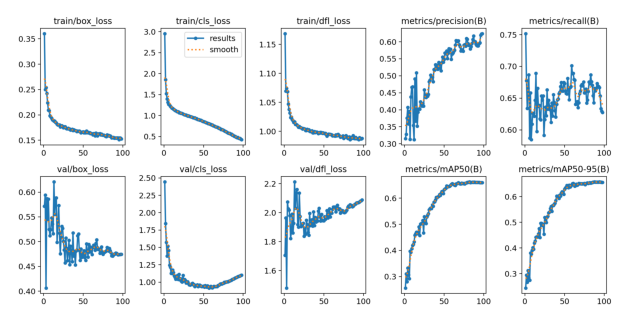

In [ ]:
from matplotlib import image as mpimg

image = mpimg.imread("runs\\detect\\train35\\results.png")
plt.imshow(image)
plt.axis('off')
plt.tight_layout()
plt.show()

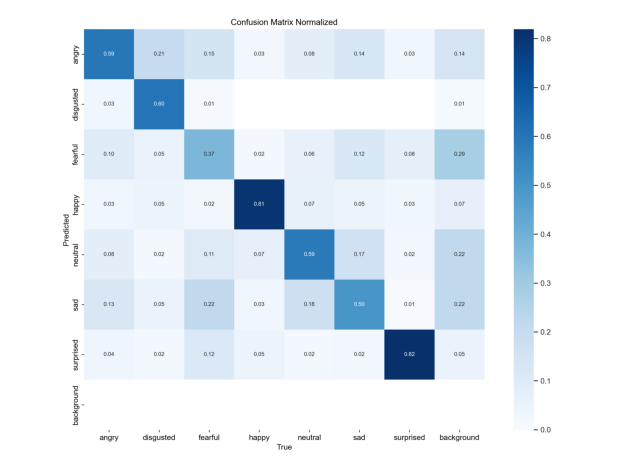

In [ ]:
from matplotlib import image as mpimg

image = mpimg.imread("runs\\detect\\val3\\confusion_matrix_normalized.png")
plt.imshow(image)
plt.axis('off')
plt.tight_layout()
plt.show()

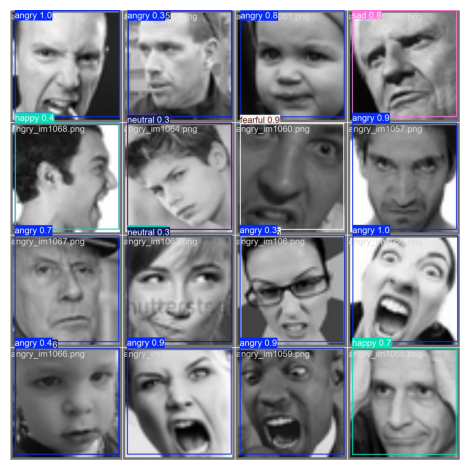

In [2]:
from matplotlib import image as mpimg

image = mpimg.imread("runs\\detect\\train35\\val_batch2_pred.jpg")
plt.imshow(image)
plt.axis('off')
plt.tight_layout()
plt.show()

In [ ]:
model.save("EmotionRec_Yolo11.pt")

### Экспорт в формат ONNX

In [ ]:
from ultralytics import YOLO

model = YOLO("EmotionRec_Yolo11.pt")

In [85]:
model.export(format="onnx")

Ultralytics 8.3.163 🚀 Python-3.11.13 torch-2.6.0+cu124 CPU (Intel Xeon 2.20GHz)

PyTorch: starting from 'EmotionRec_Yolo11.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 11, 8400) (5.1 MB)

ONNX: starting export with onnx 1.18.0 opset 19...
ONNX: slimming with onnxslim 0.1.59...
ONNX: export success ✅ 2.6s, saved as 'EmotionRec_Yolo11.onnx' (10.1 MB)

Export complete (3.0s)
Results saved to /content
Predict:         yolo predict task=detect model=EmotionRec_Yolo11.onnx imgsz=640  
Validate:        yolo val task=detect model=EmotionRec_Yolo11.onnx imgsz=640 data=dataset.yaml  
Visualize:       https://netron.app


'EmotionRec_Yolo11.onnx'

### Работа модели с видео и вебкамерой

In [93]:
from ultralytics import YOLO

model = YOLO("EmotionRec_Yolo11.onnx")

WARNING ⚠️ Unable to automatically guess model task, assuming 'task=detect'. Explicitly define task for your model, i.e. 'task=detect', 'segment', 'classify','pose' or 'obb'.


In [ ]:
def plot_bboxes(results, img, faces):
    names = results[0].names
    scores = results[0].boxes.conf.numpy()
    classes = results[0].boxes.cls.numpy()
    for score, cls in zip(scores, classes):
        class_label = names[cls]
        label = f"{class_label} : {score:0.2%}"
        lbl_margin = 3
        img = cv2.rectangle(img, (faces[0],faces[1]),(faces[0]+faces[2],faces[1]+faces[3]),
                            color=(0, 0, 255),
                            thickness=2)
        label_size = cv2.getTextSize(label,
                                     fontFace=cv2.FONT_HERSHEY_SIMPLEX,
                                     fontScale=1, thickness=2)
        lbl_w, lbl_h = label_size[0]
        lbl_w += 2* lbl_margin
        lbl_h += 2*lbl_margin
        img = cv2.rectangle(img, (faces[0], faces[1]),
                             (faces[0]+lbl_w, faces[1]-lbl_h),
                             color=(0, 0, 255),
                             thickness=-1)
        cv2.putText(img, label, (faces[0]+ lbl_margin, faces[1]-lbl_margin),
                    fontFace=cv2.FONT_HERSHEY_SIMPLEX,
                    fontScale=1.0, color=(255, 255, 255 ),
                    thickness=2)
    return img

In [91]:
def find_faces_and_plot_boxes(frame):
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')
    faces = face_cascade.detectMultiScale(frame, 1.2, 7)
    if len(faces) !=0:
        for (x,y,w,h) in faces:
            roi = frame[y:y+h, x:x+w]
        roi = cv2.cvtColor(roi, cv2.COLOR_BGR2RGB)
        with torch.inference_mode():
            results = model(roi, verbose=False)
            for result in results:
                frame = plot_bboxes(result, frame, (x,y,w,h))

    showframe(frame)
    clear_output(wait=True)
    return cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)

In [ ]:
import cv2
from moviepy import ImageSequenceClip

cap = cv2.VideoCapture("man_worried.mp4")
output_video = "video_output_Yolo.mp4"

if not cap.isOpened():
    print("Error: Could not open video file.")

frames = []
fps = int(cap.get(cv2.CAP_PROP_FPS))

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        print("Видео закончилось или появилась ошибка")
        break

    frames.append(cv2.cvtColor(find_faces_and_plot_boxes(frame), cv2.COLOR_RGB2BGR))

cap.release()
clip = ImageSequenceClip(frames, fps=fps)
clip.write_videofile(output_video, codec='libx264')

Видео закончилось или появилась ошибка
MoviePy - Building video video_output_Yolo.mp4.
MoviePy - Writing video video_output_Yolo.mp4



MoviePy - Done !
MoviePy - video ready video_output_Yolo.mp4


In [ ]:
cap = cv2.VideoCapture(0)
output_video = "webcam_output_Yolo.mp4"
frames = []
try:
    while True:
        ret, frame = cap.read()
        if not ret:
            print("Веб-камера отключена или появилась ошибка")
            break
        frame = cv2.flip(frame, 1) # переворачиваем видео веб-камеры для более приятного просмотра
        frames.append(cv2.cvtColor(find_faces_and_plot_boxes(frame), cv2.COLOR_RGB2BGR))

except KeyboardInterrupt:
    cap.release()
    clip = ImageSequenceClip(frames, fps=20)
    clip.write_videofile(output_video, codec='libx264')
    print("Веб-камера отключена")

Веб-камера отключена или появилась ошибка


# Создание интерфейса с помощью Gradio

In [ ]:
import gradio as gr
import cv2
from ultralytics import YOLO
from moviepy import ImageSequenceClip
import onnxruntime as ort
import onnx
import numpy as np
import torch

emotions = ['angry', 'disgusted', 'fearful', 'happy', 'neutral', 'sad', 'surprised']
face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml') # для детекции лиц на фото


def get_model(model_name):
    match model_name:
        case "Yolo11n":
            model = YOLO(f"{model_name}.onnx")
            ort_session = None
        case _:
            model = onnx.load(f"{model_name}.onnx")
            ort_session = ort.InferenceSession(f"{model_name}.onnx")
    return model, ort_session

def plot_frames_and_predictions(frame, onnx_model, ort_session, scaleFactor=1.2, minNeighbors=7):
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    faces = face_cascade.detectMultiScale(frame, scaleFactor, minNeighbors)
    if len(faces) !=0:
        for (x,y,w,h) in faces:
            roi = frame[y:y+h, x:x+w]
            roi = cv2.cvtColor(roi, cv2.COLOR_BGR2RGB)
            roi =  roi/255.0
            roi = cv2.resize(roi, (224, 224))
            roi = np.array(roi).astype(np.float32)  # Преобразуем в float32
            roi = roi.transpose(2, 0, 1)  # Изменяем порядок осей на [C, H, W]
            input_roi = np.expand_dims(roi, axis=0)
            outputs = ort_session.run(None, {onnx_model.graph.input[0].name: input_roi})
            predicted_class = np.argmax(outputs[0])  # Получаем класс с максимальной вероятностью
            probability = torch.nn.functional.softmax(torch.from_numpy(outputs[0]), dim=-1)[0].max() # получаем вероятность класса
            title_text = f"Pred: {emotions[predicted_class]} | {probability:.2%}"
        for (x,y,w,h) in faces:
            cv2.rectangle(frame,(x,y),(x+w,y+h),(255,0,0))
        color = (255, 255, 255)
        thickness = 3
        cv2.putText(frame, title_text, (faces[0][0], faces[0][1] -10), cv2.FONT_HERSHEY_SIMPLEX, 1, color, thickness)
    return cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)

def plot_bboxes(results, img, faces):
    names = results[0].names
    scores = results[0].boxes.conf.numpy()
    classes = results[0].boxes.cls.numpy()
    for score, cls in zip(scores, classes):
        class_label = names[cls]
        label = f"{class_label} : {score:0.2%}"
        lbl_margin = 3
        img = cv2.rectangle(img, (faces[0],faces[1]),(faces[0]+faces[2],faces[1]+faces[3]),
                            color=(0, 0, 255),
                            thickness=2)
        label_size = cv2.getTextSize(label,
                                     fontFace=cv2.FONT_HERSHEY_SIMPLEX,
                                     fontScale=1, thickness=2)
        lbl_w, lbl_h = label_size[0]
        lbl_w += 2* lbl_margin
        lbl_h += 2*lbl_margin
        img = cv2.rectangle(img, (faces[0], faces[1]),
                             (faces[0]+lbl_w, faces[1]-lbl_h),
                             color=(0, 0, 255),
                             thickness=-1)
        cv2.putText(img, label, (faces[0]+ lbl_margin, faces[1]-lbl_margin),
                    fontFace=cv2.FONT_HERSHEY_SIMPLEX,
                    fontScale=1.0, color=(255, 255, 255 ),
                    thickness=2)
    return img

def find_faces_and_plot_boxes(frame, model, scaleFactor=1.2, minNeighbors=7):
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    faces = face_cascade.detectMultiScale(frame, scaleFactor, minNeighbors)
    if len(faces) !=0:
        for (x,y,w,h) in faces:
            roi = frame[y:y+h, x:x+w]
        roi = cv2.cvtColor(roi, cv2.COLOR_BGR2RGB)
        with torch.inference_mode():
            results = model(roi, verbose=False)
            for result in results:
                frame = plot_bboxes(result, frame, (x,y,w,h))
        return cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)



def emotion_detection(video, model_name = "EfficientNet", flip_flag = False, scaleFactor=1.2, minNeighbors=7):
    output_video = f"output_{model_name}_gradio.mp4"
    cap = cv2.VideoCapture(video)
    frames = []
    fps = int(cap.get(cv2.CAP_PROP_FPS))
    model, ort_session = get_model(model_name)
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        
        if flip_flag:
            frame = cv2.flip(frame, 1)

        if model_name == "Yolo11n":
            frames.append(cv2.cvtColor(find_faces_and_plot_boxes(frame, model, scaleFactor, minNeighbors), cv2.COLOR_RGB2BGR))
        else:
            frames.append(cv2.cvtColor(plot_frames_and_predictions(frame, model, ort_session, scaleFactor, minNeighbors), cv2.COLOR_RGB2BGR))

    cap.release()
    clip = ImageSequenceClip(frames, fps=fps)
    clip.write_videofile(output_video, codec='libx264')
    return output_video



input_video = gr.Video(label="Загрузите видео или включите веб-камеру")
model_name = gr.Dropdown(choices=["EfficientNet", "ResNet18", "Yolo11n"], label="Выбор модели...")
flip_flag = gr.Checkbox(label="Перевернуть видео")
scaleFactor = gr.Number(value=1.2,minimum=1, step=0.1, label="scaleFactor", info="Параметр, определяющий, насколько сильно уменьшается размер изображения при каждом масштабе изображения")
minNeighbors = gr.Number(value=7,minimum=1, label="minNeighbors", info="Параметр, указывающий, сколько соседей должно быть у каждого подходящего прямоугольника, чтобы он сохранялся")
demo = gr.Interface(
    fn=emotion_detection,
    inputs=[input_video, model_name, flip_flag, scaleFactor,minNeighbors],
    outputs=[gr.Video()],
    title="Распознавание эмоций",
    description = "Модели распознают на видео семь базовых эмоций, которые описал американский психолог Пол Экман: -Удивление, -Страх, -Отвращение, -Гнев, -Радость, -Печаль, -Презрение."
)

demo.launch()

* Running on local URL:  http://127.0.0.1:7868
* To create a public link, set `share=True` in `launch()`.


MoviePy - Building video output_ResNet18_gradio.mp4.
MoviePy - Writing video output_ResNet18_gradio.mp4



MoviePy - Done !
MoviePy - video ready output_ResNet18_gradio.mp4
MoviePy - Building video output_ResNet18_gradio.mp4.
MoviePy - Writing video output_ResNet18_gradio.mp4



MoviePy - Done !
MoviePy - video ready output_ResNet18_gradio.mp4


# Заключение

- haarcascade_frontalface_default.xml может эффективно детектировать лица на видео​

- Были обучены три модели распознающие 7 эмоций​

- Лучшие метрики на тестовой выборке дала EfficientNet (Test loss: 0.915, Test accuracy: 0.669)​

- Все модели дали относительно похожие результаты​

- ONNXRuntime значительно уменьшил время инференса моделей​

- Был создан веб-интерфейс с помощью Gradio, который выводит считанные эмоции и процент уверенности.